Kathryn Mawhinney   
Dr. McCarthy    
Research in Health Economics    
April 6, 2025   

<h1 style="text-align: center;"><strong>Homework 4-1</strong></h1>

In this assignment, you’ll again work with the Medicare Advantage data. These data are described in detail in the Medicare Advantage GitHub Repo. We worked with a subset of these data back in assignment 1; however, this assignment requires that you work with a more complete version of the Medicare Advantage data. We’ll again focus on the years 2010-2015. Once you have the data downloaded and the code running, answer the following questions:

The due date for initial submission is 4/7, the revision due date is 4/9, and the final due date is Friday, 4/11.

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the final cleaned data
final_data = pd.read_csv("/Users/kathrynmawhinney/Documents/GitHub/Homework4/data/output/final_ma_data.csv")

/var/folders/8p/wmnjrdd55rx2pn76f5j7m2tw0000gn/T/ipykernel_20352/281459110.py:6: DtypeWarning: Columns (68,98,99,100,101,102,103,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  final_data = pd.read_csv("/Users/kathrynmawhinney/Documents/GitHub/Homework4/data/output/final_ma_data.csv")


### Summarize the Data

1. Remove all SNPs, 800-series plans, and prescription drug only plans (i.e., plans that do not offer Part C benefits). Provide a box and whisker plot showing the distribution of plan counts by county over time. Do you think that the number of plans is sufficient, too few, or too many?

In [43]:
# Confirm that all SNPs are removed
print("Any SNPs remaining?", final_data["snp"].unique())

# Confirm that no planid is in the 800–899 range (inclusive)
print("Any 800-series plans?", final_data[(final_data["planid"] >= 800) & (final_data["planid"] < 900)].shape[0])

# Confirm that all remaining plans offer Part C benefits (i.e., are not PDPs)
# If there’s a `plan_type` or `partd` column, check for drug-only plans
if "plan_type" in final_data.columns:
    print("Plan types present:", final_data["plan_type"].unique())

if "partd" in final_data.columns:
    print("Any Part D only plans?", final_data["partd"].unique())

Any SNPs remaining? ['No']
Any 800-series plans? 0
Plan types present: ['Local PPO' 'National PACE' 'HMO/HMOPOS'
 'Continuing Care Retirement Community' '1876 Cost' 'PFFS' 'ESRD I'
 'PSO (State License)' 'MSA' 'Regional PPO'
 'Medicare-Medicaid Plan HMO/HMOPOS']
Any Part D only plans? ['Yes' 'No']


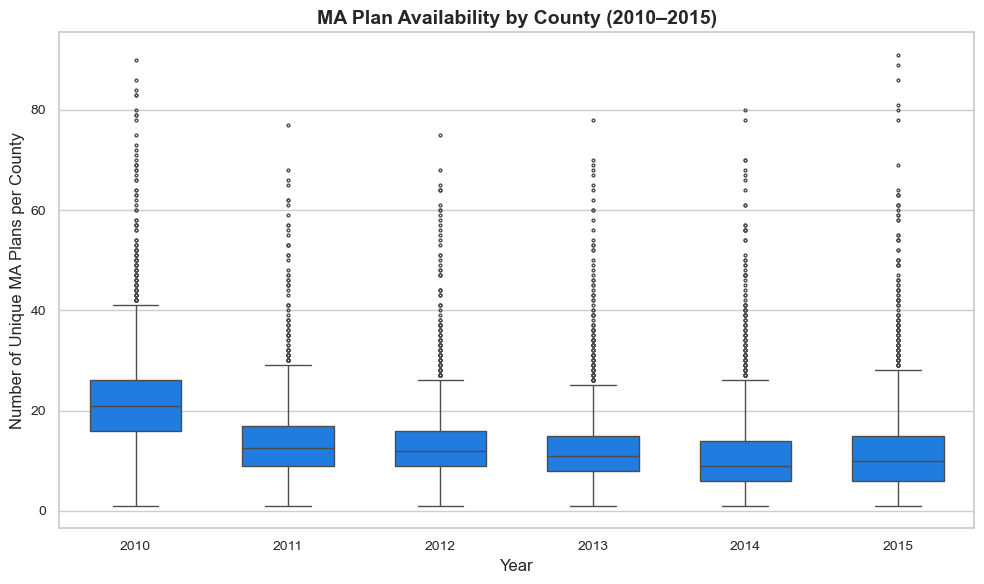

In [44]:
# Set seaborn style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=plan_counts,
    x="year",
    y="num_plans",
    color="#007BFF",  # Bright blue
    width=0.6,
    fliersize=2  # smaller outlier dots
)

# Titles and labels
plt.title("MA Plan Availability by County (2010–2015)", fontsize=14, weight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Unique MA Plans per County", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

2. Provide bar graphs showing the distribution of star ratings in 2010, 2012, and 2015. How has this distribution changed over time?

/var/folders/8p/wmnjrdd55rx2pn76f5j7m2tw0000gn/T/ipykernel_20352/1622397608.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


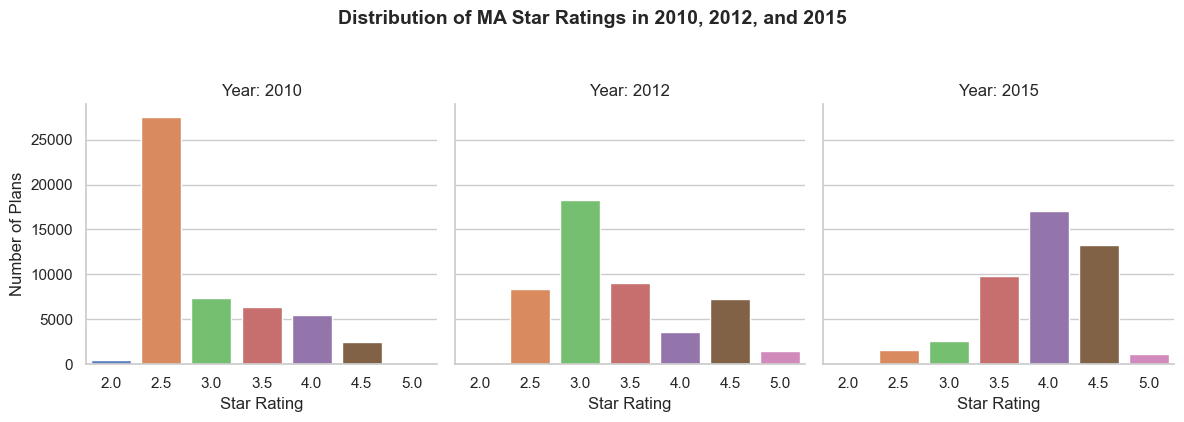

In [45]:
# Filter the data for only 2010, 2012, and 2015
selected_years = [2010, 2012, 2015]
rating_subset = final_data[final_data["year"].isin(selected_years)]

# Drop rows where Star_Rating is missing
rating_subset = rating_subset.dropna(subset=["Star_Rating"])

# Set plot style
sns.set(style="whitegrid")

# Create bar plots by year
g = sns.catplot(
    data=rating_subset,
    x="Star_Rating",
    col="year",
    kind="count",
    col_order=selected_years,
    height=4,
    aspect=1,
    palette="muted"
)

# Labeling
g.set_axis_labels("Star Rating", "Number of Plans")
g.set_titles("Year: {col_name}")
g.fig.suptitle("Distribution of MA Star Ratings in 2010, 2012, and 2015", y=1.05, fontsize=14, weight='bold')

# Display
plt.tight_layout()
plt.show()


3. Plot the average benchmark payment over time from 2010 through 2015. How much has the average benchmark payment risen over the years?

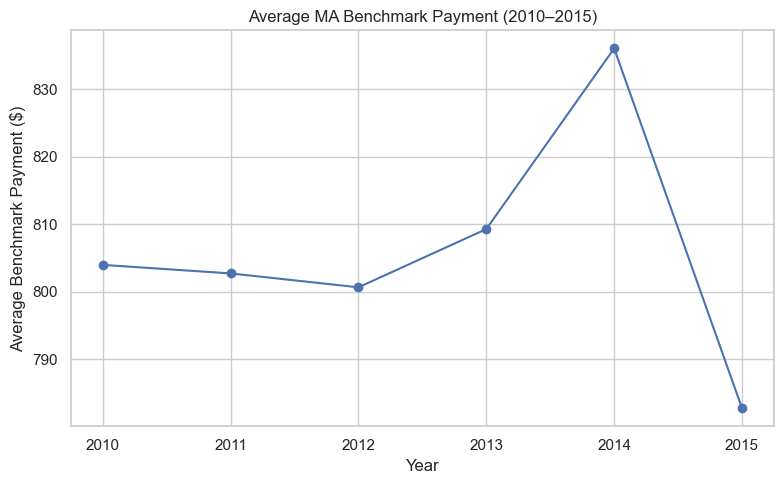

   year  avg_benchmark
0  2010     803.948611
1  2011     802.684419
2  2012     800.626973
3  2013     809.254803
4  2014     836.013611
5  2015     782.711741

Increase from 2010 to 2015: $-21.24


In [46]:
# Calculate the average benchmark payment by year
benchmark_avg = (
    final_data
    .groupby("year", as_index=False)
    .agg(avg_benchmark=("ma_rate", "mean"))
)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(benchmark_avg["year"], benchmark_avg["avg_benchmark"], marker='o')
plt.title("Average MA Benchmark Payment (2010–2015)")
plt.xlabel("Year")
plt.ylabel("Average Benchmark Payment ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display average changes
print(benchmark_avg)
print(f"\nIncrease from 2010 to 2015: ${benchmark_avg['avg_benchmark'].iloc[-1] - benchmark_avg['avg_benchmark'].iloc[0]:.2f}")

4. Plot the average share of Medicare Advantage (relative to all Medicare eligibles) over time from 2010 through 2015. Has Medicare Advantage increased or decreased in popularity? How does this share correlate with benchmark payments?

In [50]:
# Step 1: Create MA share in the penetration data
ma_penetration_data["ma_share"] = (
    ma_penetration_data["avg_enrolled"] / ma_penetration_data["avg_eligibles"]
)

# Step 2: Merge the MA share into final_data
final_data = final_data.merge(
    ma_penetration_data[["fips", "year", "ma_share"]],
    on=["fips", "year"],
    how="left"
)

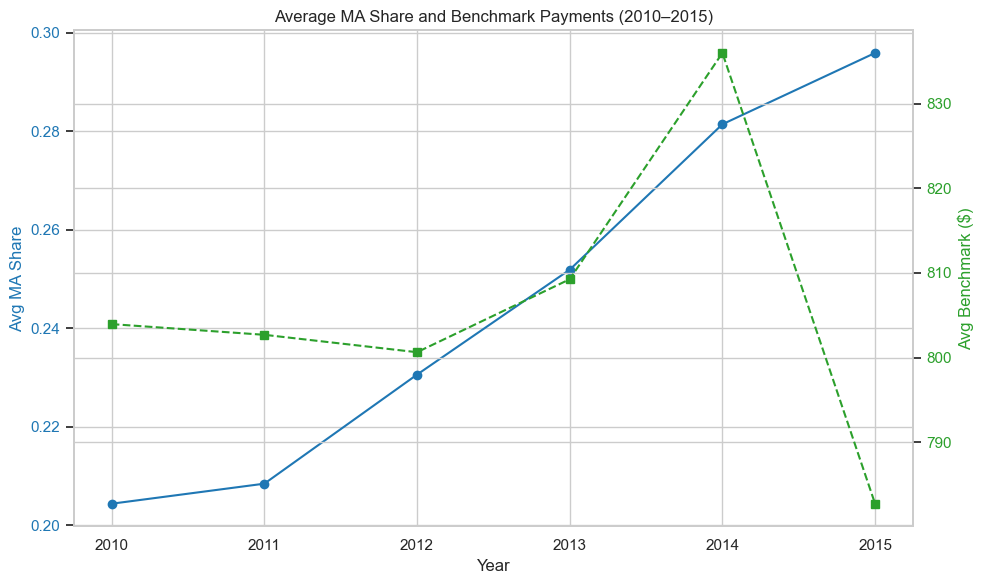

In [51]:
# Group and compute averages
penetration_trend = (
    final_data
    .groupby("year", as_index=False)
    .agg(
        avg_ma_share=("ma_share", "mean"),
        avg_benchmark=("ma_rate", "mean")
    )
)

fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:blue'
ax1.set_xlabel("Year")
ax1.set_ylabel("Avg MA Share", color=color)
ax1.plot(penetration_trend["year"], penetration_trend["avg_ma_share"], marker="o", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # second y-axis
color = 'tab:green'
ax2.set_ylabel("Avg Benchmark ($)", color=color)
ax2.plot(penetration_trend["year"], penetration_trend["avg_benchmark"], marker="s", linestyle="--", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Average MA Share and Benchmark Payments (2010–2015)")
fig.tight_layout()
plt.show()

### Estimate ATEs

For the rest of the assignment, we’ll use a regression discontinuity design to estimate the average treatment effect from receiving a marginally higher rating. We’ll focus only on 2010.

5. Calculate the running variable underlying the star rating. Provide a table showing the number of plans that are rounded up into a 3-star, 3.5-star, 4-star, 4.5-star, and 5-star rating.